# 4. Comparing data in the signal and wrong-sign containers

In data, our signal $B^0$ candiates are formed by combining a $D^{*-}$ with two positive pions and a negative pion (or a $D^{*+}$ with two negative pions and a positive one). Overall, the electric charge of this combination is zero, as expected for a $B^0$ decay.

Not all of the combinations in data are going to be genuine signal - sometimes you combine pions from some other process in the event, which adds background to your sample. We call this type of background `combinatorial`. We can mimic this type of background in data by creating so-called `wrong-sign` combinations. Here, we take a $D^{*-}$ and combine it with two negative pions and a positive one. The overall charge combination here is clearly non-physical, which means the sample won't include any genuine signal decays. Thus, it gives us an idea of what the background looks like when you randomly add together pions.

**A: The goal of the wrong-sign data is to have an idea of the proportion of background candidates in our sample**


As part of this project, we will train a machine learning algorithm to learn the differences between genuine signal decays and combinatorial background. We can use `scikit-learn` to do this, employing `Gradient Boosted Decision Trees` (BDT). We can compare our signal MC sample of $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ with the wrong-sign background in data, giving the BDT a list of variables to compare. The BDT then gives us a classifier decision variable, which we can use to discriminate between signal and background in our real data. 

Some imports of what we need:

In [2]:
from root_pandas import read_root
import matplotlib.pyplot as plt
from bd2dst3pi.locations import loc
import numpy as np
import pandas as pd
import matplotlib
from bd2dst3pi.definitions import years, magnets

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)
matplotlib.rcParams['axes.unicode_minus'] = False

# import sys
# sys.path.append(loc.SCRIPTS)
# import functions as fct

In [3]:
import uproot4

Let's load the signal candidate data and the wrong-sign data into some DataFrames:

In [6]:
df = {}
file_list_sig = []
for y in years:
    for m in magnets:
        print(f"{loc.DATA_STRIP_p}/data_90000000_{y}_{m}.root")
        file_list_sig.append(f"{loc.DATA_STRIP_p}/data_90000000_{y}_{m}.root")
tree_name = "DecayTreeTuple/DecayTree"
vars = ["B0_M","Dst_M","D0_M"]
df["sig"] = read_root(file_list_sig, tree_name, columns=vars)

file_list_ws = []
for y in years:
    for m in magnets:
        print(f"{loc.DATA_WS_STRIP}/dataWS_90000000_{y}_{m}.root")
        file_list_ws.append(f"{loc.DATA_WS_STRIP}/dataWS_90000000_{y}_{m}.root")
tree_name = "DecayTreeTuple/DecayTree"
df["ws"] = read_root(file_list_ws, tree_name, columns=vars) # ws = wrong sign

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/dataWS/dataWS_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/dataWS/dataWS_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/dataWS/dataWS_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/dataWS/dataWS_90000000_2016_down.root


(array([6309., 6326., 6604., 6554., 6752., 6854., 7086., 7191., 7294.,
        7542., 7604., 7657., 7702., 7727., 7853., 8044., 8221., 8306.,
        8261., 8456., 8367., 8587., 8554., 8509., 8543., 8761., 8819.,
        9131., 9020., 9015., 9188., 9223., 9277., 9216., 9306., 9332.,
        9242., 9354., 9412., 9346., 9496., 9268., 9453., 9277., 9374.,
        9501., 9364., 9428., 9493., 9495., 9458., 9371., 9274., 9460.,
        9321., 9443., 9492., 9352., 9367., 9280., 9309., 9136., 9167.,
        9138., 9010., 9144., 9198., 9116., 9014., 8774., 8969., 8799.,
        8797., 8740., 8596., 8609., 8731., 8467., 8629., 8583., 8455.,
        8414., 8193., 8294., 8271., 8389., 8276., 8158., 8219., 8013.,
        7966., 7799., 7962., 7845., 7921., 7615., 7633., 7751., 7511.,
        7549.]),
 array([3000., 3010., 3020., 3030., 3040., 3050., 3060., 3070., 3080.,
        3090., 3100., 3110., 3120., 3130., 3140., 3150., 3160., 3170.,
        3180., 3190., 3200., 3210., 3220., 3230., 3240., 325

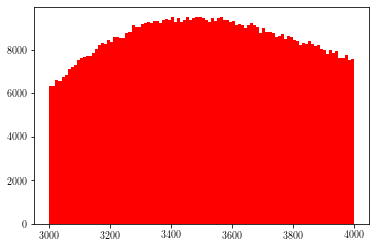

In [18]:
plt.hist(df['ws']['B0_M'], bins=100, range=(3000, 4000), color='r')

Let's calculate the $\Delta M = m(D^*) - m(D^0)$ for each sample:

In [7]:
for d in df:
    df[d]["Delta_M"] = df[d]["Dst_M"] - df[d]["D0_M"]

Plotting the $\Delta M$ shows us that quite a lot of the data is from fake $D^*$ combinations:

In [8]:
# Range, bit, units
low_Delta_M = 142.
high_Delta_M = 150.
bin_width = 0.2
units = "MeV/$c^2$"
n_bins = int((high_Delta_M - low_Delta_M)/bin_width)

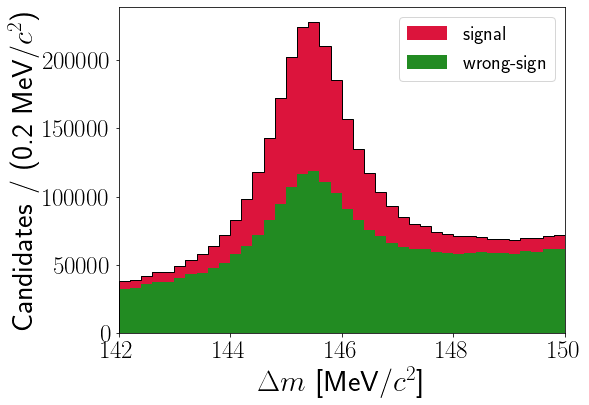

In [9]:
fig, ax = plt.subplots(figsize=(8,6))



# Plot of the histograms
plt.hist(df["sig"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='step',color='k')
plt.hist(df["sig"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='stepfilled',color='crimson',label='signal')
plt.hist(df["ws"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='stepfilled',color='forestgreen',label='wrong-sign')

# Label, limits
plt.xlim(low_Delta_M,high_Delta_M)
plt.xlabel("$\Delta m$ [%s]" % units,fontsize=30)
plt.ylabel(f"Candidates / ({bin_width:.1f} {units})", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=20)
plt.show()

The wrong-sign data still contains some real $D^*$'s as well, since it is possible to combine a real $D^*$ with some random pions to make a wrong-sign candidate. 

Let's clean up our samples a bit by cutting on $143 < \Delta m < 148$:

In [10]:
for d in df:
    df[d] = df[d].query("Delta_M > 143. and Delta_M < 148.")

Now we plot the $B^0$ candidate masses in the remaining signal and wrong-sign data:

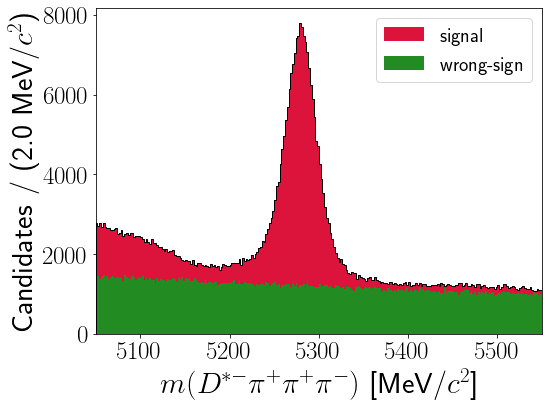

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

# Range, bit, units
low = 5050.
high = 5550.
bin_width = 2.
n_bins = int((high - low)/bin_width)

# Plot hists
plt.hist(df["sig"]["B0_M"], bins=n_bins, range=(low,high),histtype='step',color='k')
plt.hist(df["sig"]["B0_M"], bins=n_bins, range=(low,high),histtype='stepfilled',color='crimson',label='signal')
plt.hist(df["ws"]["B0_M"], bins=n_bins, range=(low,high),histtype='stepfilled',color='forestgreen',label='wrong-sign')

# lim, label
plt.xlim(low,high)
plt.xlabel("$m(D^{*-}\pi^+\pi^+\pi^-)$ [MeV/$c^2$]",fontsize=30)
plt.ylabel(f"Candidates / ({bin_width:.1f} {units})", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=20)
plt.show()

There are a few things to notice in this plot:
- Only the signal data, where we have the correct charge combination, has a $B^0$ peak.
- The wrong-sign data is similar to the signal data in the upper mass region. This is the region where there shouldn't be any physical combinations. The fact that the distributions don't agree perfectly means that the probability of having a random combination $D^{*-}$ + $\pi^+ \pi^- \pi^-$ isn't quite the same as a random combination $D^{*-}$ + $\pi^+ \pi^+ \pi^-$. But it's clear that the general shape of the background in this region is very similar. 
- There are extra events in the signal data at low mass (below 5150 MeV). These are from decays such as $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- \pi^0$, where a neutral pion produced in the decay is not reconstructed. Why do such decays sit at lower mass values?


Why the pic $m(D^{*-} \pi^+ \pi^+ \pi^-)$ of $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- \pi^0$ stands at a lower mass values than the one of  $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$?
This is because:
- For $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$, $m(D^{*-} \pi^+ \pi^+ \pi^-)$ has a peak around the mass of $m_{B^0}$
- For $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- \pi^0$, the peak corresponds to $m(D^{*-} \pi^+ \pi^+ \pi^-)=\sqrt{\left(p_{B^0}-p_{pi^0}\right)^2}$. For a given energy E of $B^0$, the energy is shared between $\pi^0$ and $D^{*-} \pi^+ \pi^+ \pi^-$. Then, the invariant mass of $D^{*-} \pi^+ \pi^+ \pi^-$ is lower than $m_{B^0}$.

**Follow-up tasks**
- Use the wrong-sign data samples and the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ signal MC to train a BDT. The BDTs job will be to classify events as signal or combinatorial background. You will need to choose some input variables from your tree to train the classifier (see below).
- Apply this BDT to the **signal data**, which has not been used in the training. The result should be a BDT distribution for the signal data, with high values corresponding to a high signal probability and a low value corresponding to a high background probability.
- You can use [scikit-learn](https://scikit-learn.org/stable/) for this sort of task. You'll find a ROOT-based tutorial [here](https://betatim.github.io/posts/sklearn-for-TMVA-users/).
- Prepare a plot of the signal MC and wrong-sign data BDT distributions. How do they compare? Are they well separated?
- Can you make a ROC curve of the BDT performance?
- How does the BDT distribution look in the signal data?
- What happens to the $m(B^0)$ distribution in the signal data when you apply a cut to the BDT?

Some ideas for variables to use in the BDT, to discriminate between signal and wrong-sign background:
 - `B0_P` and `B0_PT` ($B^0$ candidate kinematics)
 - `D0_P` and `D0_PT` ($D^0$ candidate kinematics)
 - `Dst_P` and `Dst_PT` ($D^*$ candidate kinematics)
 - `tau_pion0_P` and `tau_pion0_PT`, and the same for `tau_pion1` and `tau_pion2` (three pions kinematics)
 - `tau_pion0_TRACK_CHI2NDOF`, and the same for `tau_pion1` and `tau_pion2` (three pions track fit quality)
 - `B0_ENDVERTEX_CHI2` ($B^0$ vertex quality)
 - `D0_ENDVERTEX_CHI2` ($D^0$ vertex quality)
 - `tau_ENDVERTEX_CHI2` ($3\pi$ vertex quality)

## Pre-task 1 - Compare the distributions between MC and data

In order not to overtrain our BDT, we compare the distributions of some variables and choose the variables which has a different MC and data distribution.

First, some functions to plot histograms

In [3]:
# def list_into_string(L, sep = '_'):
#     string = ""
#     for l in L:
#         string += str(l)
#         string += sep
#     return string[:-len(sep)]

# def plot_hist(dfs, variable, name_variable, unit_variable, n_bins = 100, mode_hist = False, 
#               low = None, high = None, density = None):
#     """
#     Plot the histogram of particle_variable, with number of bins = 100
    
#     If df is a dictionnary:
#     dfs={name_data:panda_dataframe,...}
#     --> Plot several histograms in the same plot
    
#     if mode_hist is on, I use histograms with density = True/False
    
#     """
#     if density is None:
#         density = len(dfs)>1 # if there are more than 2 histograms
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     name_datas = list(dfs.keys())
    
#     if name_variable is None:
#         name_variable = variable
        
#     # Some features of the variable/particle
# #     units_var = variables[variable]['unit']
# #     name_var = variables[variable]['name']
#     #name_particle = particle_names[particle]
    
    
#     # Compute the number of bins
#     #bin_width = 4
    
#     #First loop to determine the low and high value
#     define_low = low is None
#     define_high = high is None
#     if define_low or define_high:
#         if define_low: 
#             low = np.inf
#         if define_high:
#             high = -np.inf
#         for name_data, df in dfs.items():
#             if define_low:
#                 low = min(low,df[variable].min())
#             if define_high:
#                 high = max(high,df[variable].max())

#     bin_width = (high-low)/n_bins
    
#     colors = ['r','b','g','k']
#     k_col = 0
    
#     labels = []
#     for name_data, df in dfs.items():
        
#         if mode_hist:
#             alpha = 0.5 if density else 1            
#             counts,bin_edges = np.histogram(df[variable], range = [low,high],bins = n_bins)
#             centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#             n_candidates = counts.sum()
#             label= f"{name_data}: {n_candidates} candidates" if density else None
#             if density:
#                 counts = counts / n_candidates
#             plt.bar(centers, counts, centers[1]-centers[0], alpha = alpha,label = label)
#         else:
#             #Make the histogram, and get the bin centres and error on the counts in each bin
#             counts, bin_edges = np.histogram(df[variable], n_bins, range=(low,high))
#             n_candidates = counts.sum()
#             label= f"{name_data}: {n_candidates} candidates" if density else None
#             #n_candidates = counts.sum()
#             bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
#             #Plot the bin centres and counts in each bin
#             err = np.sqrt(counts)
#             if density:
#                 counts = counts/(n_candidates*bin_width)
#                 err = err/(n_candidates*bin_width)
#             plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color=colors[k_col], label = label)
#         k_col += 1
              
#     #Some plot style stuff
#     #Set the x title
#     plt.xlabel("%s [%s]" %(name_variable,unit_variable),fontsize=30)
    
#     #Set the y-title, which is number of candidates per bin
#     ylabel = "Proportion of candidates" if density else "Candidates"
#     fontsize = 25 if density else 30
#     plt.ylabel(f"{ylabel} / ({bin_width:.1g} {unit_variable})", fontsize=fontsize)

#     #Set lower and upper range of the x-axis
#     plt.xlim(low,high)
    
#     #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
#     ymin, ymax = plt.ylim()
#     plt.ylim(0.,ymax*1.4)

#     #Set the font size of the axis numbers
#     ax.tick_params(axis='both', which='major', labelsize=25)

#     #Legend
#     if density:
#         plt.legend(fontsize = 20)
    
#     #Remove any space not needed around the plot
#     plt.tight_layout()

#     plt.show()

#     #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
#     fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas)}.pdf")

# def plot_divide(dfs, variable, name_variable,unit_variable, n_bins = 100, low = None, high = None):
#     """
#     dfs={name_data1:df1,name_data2:df2}
#     plot the (histogram name_data1)/(histogram of namedata2) AFTER NORMALISATION ofc.
        
#     """
       
#     fig, ax = plt.subplots(figsize=(8,6))
#     name_datas = list(dfs.keys())
    
    
#     # Compute the number of bins
#     #bin_width = 4
    
#     ##First loop to determine the low and high value
#     define_low = low is None
#     define_high = high is None
#     if define_low or define_high:
#         if define_low: 
#             low = np.inf
#         if define_high:
#             high = -np.inf
#         for name_data, df in dfs.items():
#             if define_low:
#                 low = min(low,df[variable].min())
#             if define_high:
#                 high = max(high,df[variable].max())
    
#     bin_width = (high-low)/n_bins
    
#     labels = []
#     #Make the histogram, and get the bin centres and error on the counts in each bin
#     list_dfs = list(dfs.values())
#     list_type_data = list(dfs.keys())
#     counts1, bin_edges = np.histogram(list_dfs[0][variable], n_bins, range=(low,high))
#     counts2, _ = np.histogram(list_dfs[1][variable], n_bins, range=(low,high))
#     bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
#     err1 = np.sqrt(counts1)
#     err2 = np.sqrt(counts2)
    
#     #division
    
#     division = counts1*counts2.sum()/(counts2*counts1.sum()) 
#     err = division*np.sqrt((err1/counts1)**2+(err2/counts2)**2)

#     plt.errorbar(bin_centres, division, yerr=err, fmt='o', color='k')
#     plt.plot([low,high], [1.,1.], linestyle='--', color='b',marker='')
#     #Some plot style stuff
#     #Set the x title
#     plt.xlabel(f"{name_variable}[{unit_variable}]",fontsize=30)
    
#     #Set the y-title, which is number of candidates per bin
#     plt.ylabel("candidates[%s] / candidates[%s] \n / (%.1g {%s})"%(list_type_data[0],
#                                                                    list_type_data[1],
#                                                                    bin_width,
#                                                                    unit_variable), 
#                fontsize=30)

#     #Set lower and upper range of the x-axis
#     plt.xlim(low,high)
    
#     #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
#     ymin, ymax = plt.ylim()
#     plt.ylim(0.,ymax*1.2)

#     #Set the font size of the axis numbers
#     ax.tick_params(axis='both', which='major', labelsize=25)

    
#     #Remove any space not needed around the plot
#     plt.tight_layout()

#     plt.show()

#     #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
#     fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas,'_d_')}.pdf")



Load MC and real data

In [4]:
# def load_data(years,magnets,type_data = 'data', vars = ['*']):
#     """
#     type_data = 'MC', 'data', 'data_strip', 'ws_strip'
#     """
#     tree_name = "DecayTree"
#     if type_data == 'MC':
#         path = f"{loc.MC}/Bd_Dst3pi_11266018"
#         ext = '_Sim09e-ReDecay01.root'
#     elif type_data == 'data':
#         path = f"{loc.DATA}/data_90000000"
#         ext = '.root'
#     elif type_data == 'MCc':
#         path = f"{loc.MC}/Bd_Dst3pi_11266018"
#         ext = '_Sim09c-ReDecay01.root'
#     elif type_data == 'MCe':
#         path = f"{loc.MC}/Bd_Dst3pi_11266018"
#         ext = '_Sim09e-ReDecay01.root'
#     elif type_data == 'data_strip':
#         path = f"{loc.DATA_STRIP}/data_90000000"
#         ext = '.root'
#         tree_name = "DecayTreeTuple/DecayTree"
#     elif type_data == 'ws_strip':
#         path = f"{loc.DATA_WS_STRIP}/dataWS_90000000"
#         ext = '.root'
#         tree_name = "DecayTreeTuple/DecayTree"
#     else:
#         print("Possible type of data: 'MC', 'data', 'data_strip', 'ws_strip'")
    
#     dfr = {}
#     dfr_tot = pd.DataFrame()
#     for y in years:
#         for m in magnets:
#             print(f"{path}_{y}_{m}{ext}")
#             dfr[f"{y}_{m}"] = read_root(f"{path}_{y}_{m}{ext}",tree_name, columns=vars)
            
#             dfr_tot = dfr_tot.append(dfr[f"{y}_{m}"])
#     return dfr, dfr_tot


In [6]:
# variables_params = {
#     'P' : {
#         'name': "p",
#         'unit': "MeV/c"
#     },
#     'PT': 
#     {
#         'name': "$p_T$",
#         'unit': "MeV/c"
#     },
#     'M': 
#     {
#         'name': "$m$",
#         'unit': "MeV/$c^2$"
#     },
#     'flight_z':
#     {
#         'name': "$\Delta z$",
#         'unit': "$\mu m$"
#     },
#     'flight_zsig':
#     {
#         'name': "$\Delta z$ significance",
#         'unit': ""
#     },
#     'ENDVERTEX_CHI2':
#     {
#         'name': None,
#         'unit': ""
#     },
#     'TRACK_CHI2NDOF':
#     {
#         'name': None,
#         'unit': ""
#     }
    
# }

# particle_names = {
#     'B0':'$D^{*-}\pi^+\pi^+\pi^-$',
#     'Dst':'$D^*$',
#     'tau':'$\pi^+ \pi^+ \pi^-$',
#     'tau_pion0':'$\pi_0$',
#     'tau_pion1':'$\pi_1$',
#     'tau_pion2':'$\pi_2$'
# }

# def plot_hist_particle(dfs, particle, variable, n_bins = 100, mode_hist = False, 
#                        low = None, high = None):
#     name_variable = variables_params[variable]['name']
#     unit_variable = variables_params[variable]['unit']
#     name_particle = particle_names[particle]
#     if name_variable is None:
#         name_variable = f"{particle}-{variable}".replace('_',' ')
#     else:
#         name_variable = f"{name_variable}({name_particle})"
#     plot_hist(dfs, f"{particle}_{variable}", name_variable, unit_variable, n_bins = n_bins, mode_hist = mode_hist,
#              low = low, high = high)

# def plot_divide_particle(dfs, particle, variable, n_bins = 100,low = None, high = None):
#     name_variable = variables_params[variable]['name']
#     unit_variable = variables_params[variable]['unit']
    
#     plot_divide(dfs, f"{particle}_{variable}", name_variable, unit_variable, n_bins = n_bins,
#              low = low, high = high)   

 - `B0_P` and `B0_PT` ($B^0$ candidate kinematics)
 - `D0_P` and `D0_PT` ($D^0$ candidate kinematics)
 - `Dst_P` and `Dst_PT` ($D^*$ candidate kinematics)
 - `tau_pion0_P` and `tau_pion0_PT`, and the same for `tau_pion1` and `tau_pion2` (three pions kinematics)
 - `tau_pion0_TRACK_CHI2NDOF`, and the same for `tau_pion1` and `tau_pion2` (three pions track fit quality)
 - `B0_ENDVERTEX_CHI2` ($B^0$ vertex quality)
 - `D0_ENDVERTEX_CHI2` ($D^0$ vertex quality)
 - `tau_ENDVERTEX_CHI2` ($3\pi$ vertex quality)

In [3]:
part_variables_to_plot = [] # particle,variable

for particle in ['B0', 'Dst', 'tau_pion0', 'tau_pion1', 'tau_pion2']:
    part_variables_to_plot.append((particle,'P'))
    part_variables_to_plot.append((particle,'PT'))

for particle in ['B0', 'Dst', 'tau']:
    part_variables_to_plot.append((particle,'ENDVERTEX_CHI2'))

for particle in ['tau_pion0', 'tau_pion1', 'tau_pion2']:
    part_variables_to_plot.append((particle,'TRACK_CHI2NDOF'))

variables = []
for particle, variable in part_variables_to_plot:
    variables.append(f"{particle}_{variable}")
print(variables)

['B0_P', 'B0_PT', 'Dst_P', 'Dst_PT', 'tau_pion0_P', 'tau_pion0_PT', 'tau_pion1_P', 'tau_pion1_PT', 'tau_pion2_P', 'tau_pion2_PT', 'B0_ENDVERTEX_CHI2', 'Dst_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2', 'tau_pion0_TRACK_CHI2NDOF', 'tau_pion1_TRACK_CHI2NDOF', 'tau_pion2_TRACK_CHI2NDOF']


In [8]:
#from root_numpy import root2array, rec2array

dfa_tot = {}
dfa = {}


vars = variables
dfa['MC'], dfa_tot['MC'] = load_data(years,magnets,type_data = 'MC',vars = variables)
dfa['data_strip'], dfa_tot['data_strip'] = load_data(years[:1],magnets,type_data = 'data_strip',vars = variables)
dfa['ws_strip'], dfa_tot['ws_strip'] = load_data(years[:1],magnets,type_data = 'ws_strip',vars = variables)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/dataWS/dataWS_90000000_2015_up.root


In [ ]:
#print(len(dfa_tot["ws_strip"]))

In [ ]:
# for particle, variable in part_variables_to_plot:
#     plot_hist_particle({'MC':dfa_tot['MC'], 'background':dfa_tot['ws_strip']}, 
#                        particle, variable, n_bins = 100, mode_hist = True)
    # plot_divide_particle({'MC':df_tot['MC'],'MC':df_tot['MC'], }, particle, variable, 
    #                  n_bins = 100)

## Pre-task 2 - Visualisation of the data

### Import

In [9]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
import random
import pandas.core.common as com
from pandas.core.index import Index

from pandas import plotting
from pandas.plotting import scatter_matrix

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ROOT/_facade.py:121: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  return _orig_ihook(name, *args, **kwds)


Concatenate Signal and Background and create a variable *y* with
- y = 1 if signal
- y = 0 if background

In [10]:
def concatenate(dfa_tot):
    # Concatenated data
    X = np.concatenate((dfa_tot['MC'], dfa_tot['ws_strip']))
    # List of 1 for signal and 0 for background (mask)
    y = np.concatenate((np.ones(dfa_tot['MC'].shape[0]),
                        np.zeros(dfa_tot['ws_strip'].shape[0])))
    print(y)

    # Concatened dataframe of signal + background, with a new variable y:
    # y = 0 if background
    # y = 1 if signal
    df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                      columns=variables+['y'])
    return X, y, df
X, y, df = concatenate(dfa_tot)

[1. 1. 1. ... 0. 0. 0.]


### 1D histograms

In [12]:
# it's an adaptation of hist_frame of  pandas.plotting._core
def signal_background(data1, data2, column=None,range_column = None, grid=True,
                      xlabelsize=None, ylabelsize=None,
                      sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=40,name_file = None, **kwds):
    """Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.
    
    data1: DataFrame
    data2: DataFrame
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    grid : boolean, default True
        Whether to show axis grid lines
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    sharex : bool, if True, the X axis will be shared amongst all subplots.
    sharey : bool, if True, the Y axis will be shared amongst all subplots.
    figsize : tuple
        The size of the figure to create in inches by default
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """
    rc('text', usetex=False)
    if 'alpha' not in kwds:
        kwds['alpha'] = 0.5

    
    if column is not None:
        # column is not a list, convert it into a list.
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]
        
    data1 = data1._get_numeric_data() # select only numbers
    data2 = data2._get_numeric_data() # seject only numbers
    naxes = len(data1.columns) # number of axes = number of available columns
    
    max_nrows = 4
    # subplots
    fig, axes = plt.subplots(nrows=min(naxes,max_nrows), ncols = 1+naxes//max_nrows , squeeze=False,
                                   sharex=sharex,
                                   sharey=sharey,
                                   figsize=figsize)
#     fig, axes = _subplots(naxes=naxes, ax=ax, squeeze=False,
#                           sharex=sharex, sharey=sharey, figsize=figsize,
#                           layout=layout)
    _axes = axes.flat

    if range_column is None:
        range_column = [[None,None] for i in range(len(columns))]
    for i, col in enumerate(data1.columns): # data.columns = the column labels of the DataFrame.
        # col = name of the column/variable
        ax = _axes[i]
        
        if range_column[i] is None:
            range_column[i] = [None,None]
        if range_column[i][0] is None:
            low = min(data1[col].min(), data2[col].min())
        else:
            low = range_column[i][0]
        if range_column[i][1] is None:
            high = max(data1[col].max(), data2[col].max())
        else:
            high = range_column[i][1]
        ax.hist(data1[col].dropna().values, # .dropna() for removing missing values.
                bins=bins, range=(low,high), label = "background",density = True, **kwds)
        ax.hist(data2[col].dropna().values,
                bins=bins, range=(low,high),label = "signal", density = True, **kwds)
        ax.set_title(col, fontsize = 20)
        ax.grid(grid)
        ax.legend(fontsize = 20)
    i+=1
    while i<len(_axes):
        ax = _axes[i]
        ax.axis('off')
        i+=1

    #fig.subplots_adjust(wspace=0.3, hspace=0.7)
    if name_file is None:
        name_file = list_into_string(column)
    fig.savefig(f"{loc.PLOTS}/BDT/1D_hist_{name_file}.pdf")
    return axes

# Plot signal and background distributions for some
# variables
# The first two arguments select what is "signal"
# and what is "background". This means you can
# use it for more general comparisons of two
# subsets as well.

array([[<AxesSubplot:title={'center':'B0_P'}>,
        <AxesSubplot:title={'center':'B0_PT'}>,
        <AxesSubplot:title={'center':'Dst_P'}>,
        <AxesSubplot:title={'center':'Dst_PT'}>,
        <AxesSubplot:title={'center':'tau_pion0_P'}>],
       [<AxesSubplot:title={'center':'tau_pion0_PT'}>,
        <AxesSubplot:title={'center':'tau_pion1_P'}>,
        <AxesSubplot:title={'center':'tau_pion1_PT'}>,
        <AxesSubplot:title={'center':'tau_pion2_P'}>,
        <AxesSubplot:title={'center':'tau_pion2_PT'}>],
       [<AxesSubplot:title={'center':'B0_ENDVERTEX_CHI2'}>,
        <AxesSubplot:title={'center':'Dst_ENDVERTEX_CHI2'}>,
        <AxesSubplot:title={'center':'tau_ENDVERTEX_CHI2'}>,
        <AxesSubplot:title={'center':'tau_pion0_TRACK_CHI2NDOF'}>,
        <AxesSubplot:title={'center':'tau_pion1_TRACK_CHI2NDOF'}>],
       [<AxesSubplot:title={'center':'tau_pion2_TRACK_CHI2NDOF'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

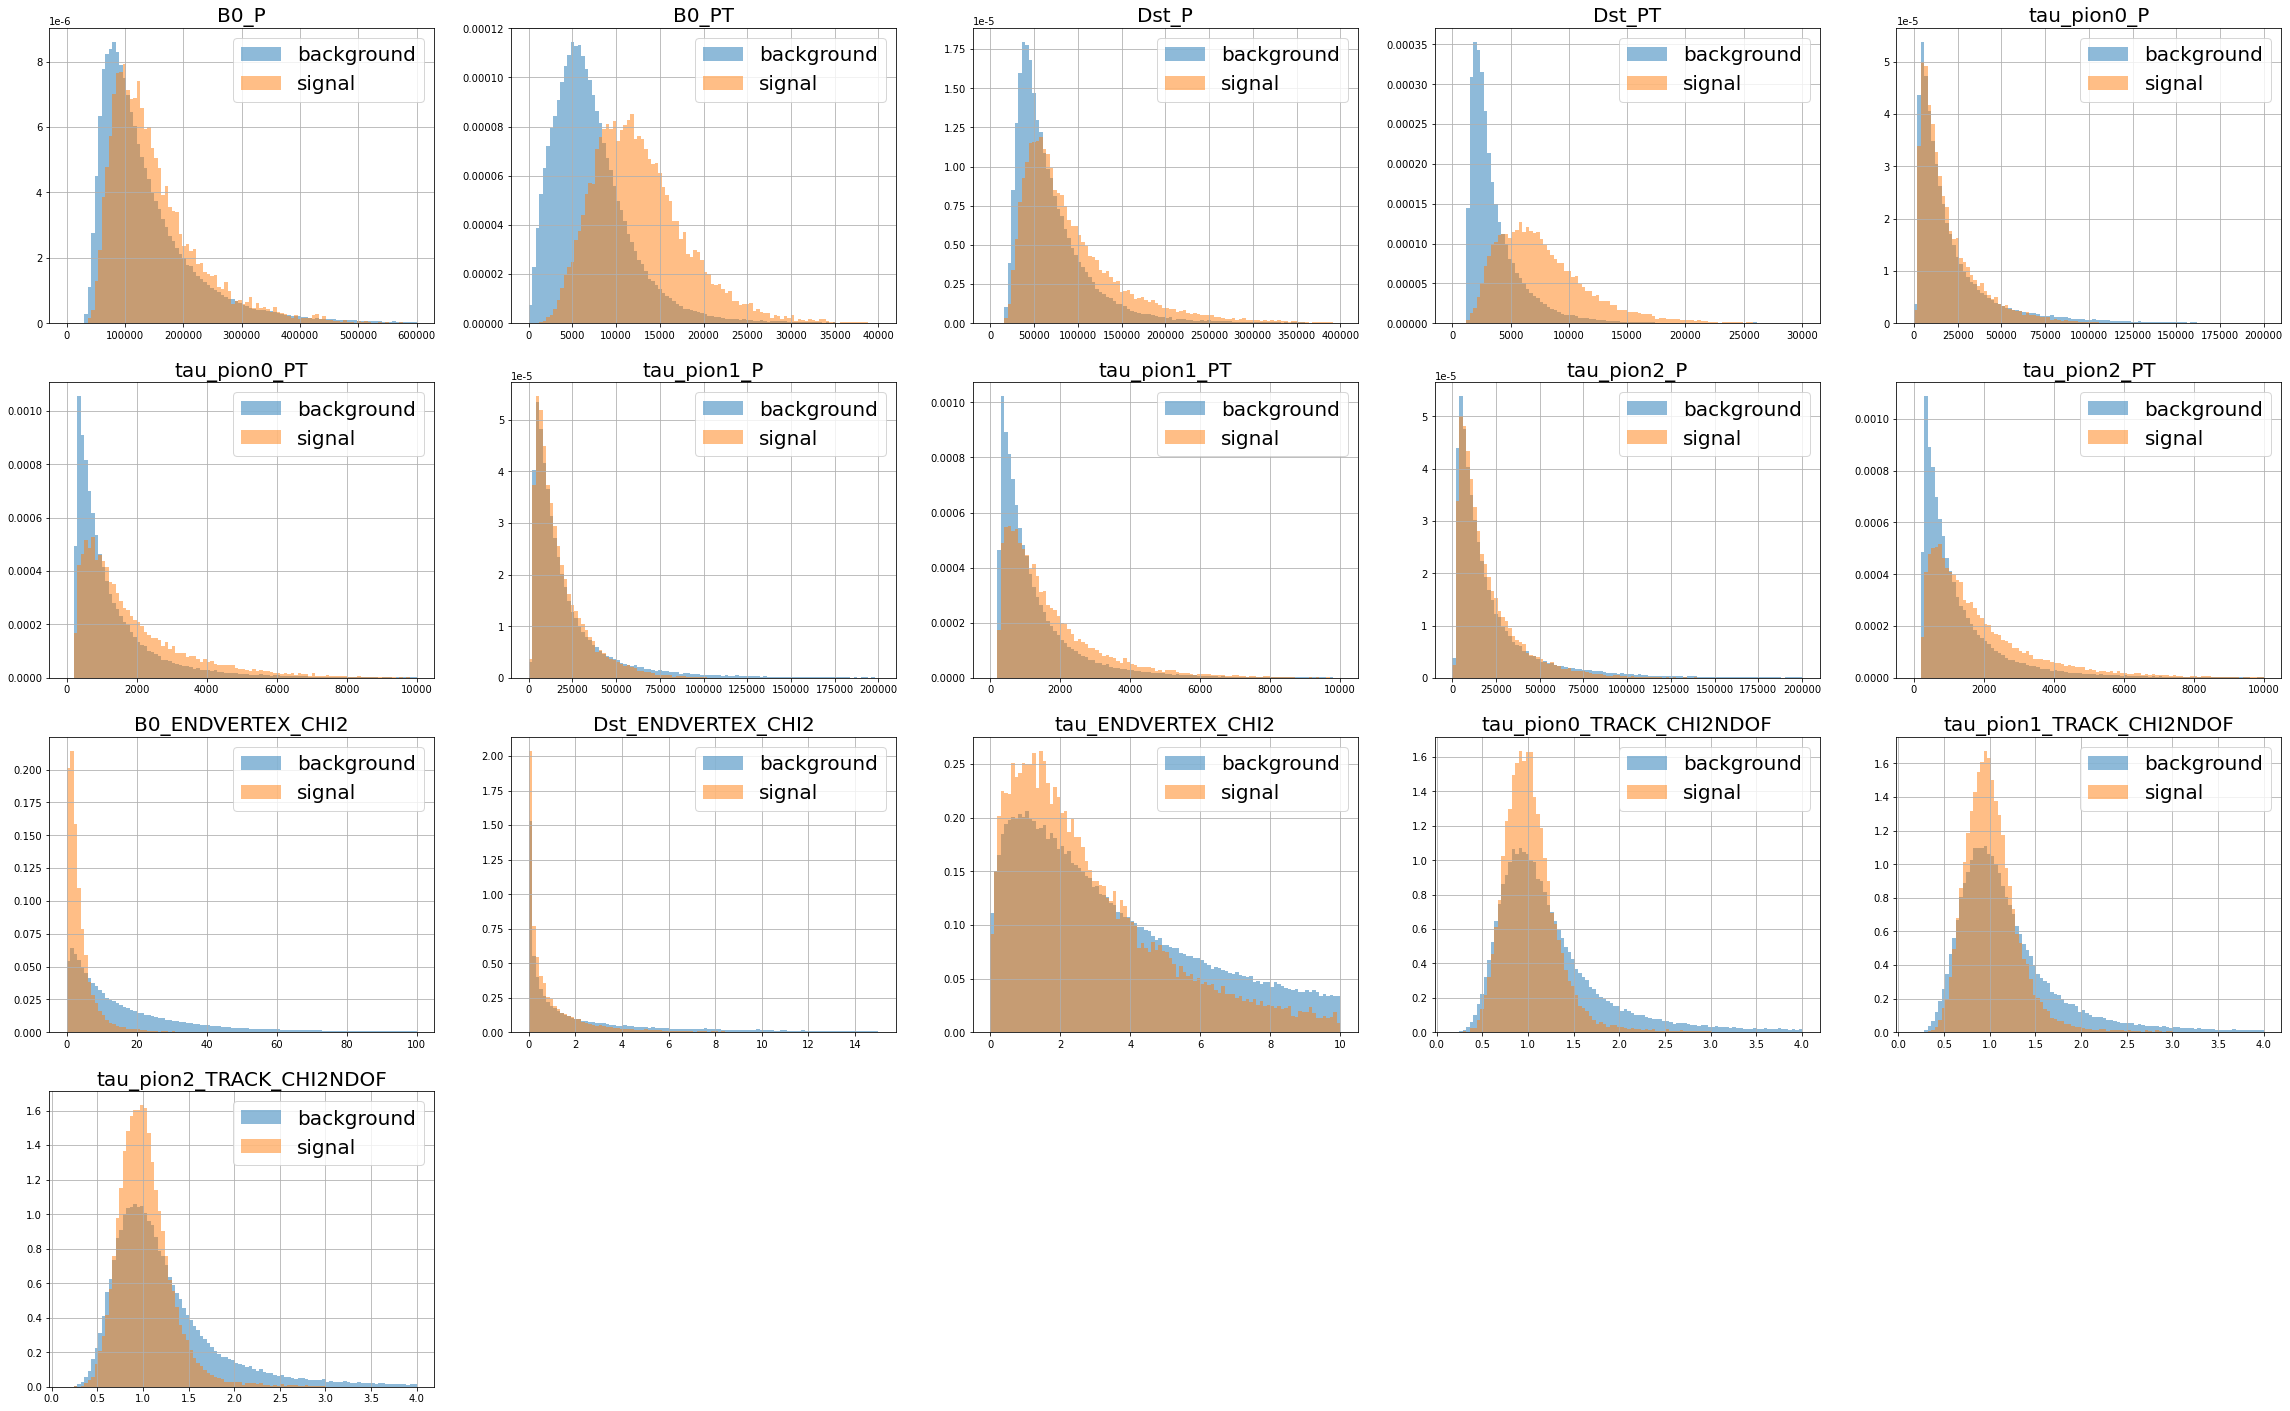

In [18]:
signal_background(df[df.y<0.5], df[df.y>0.5],
                  column=variables,
                  range_column=[
                      [0,6e5],
                      [0,40000],
                      [0,4e5],
                      [0,30000],
                      [0,2e5],
                      [0,10000],
                      [0,2e5],
                      [0,1e4],
                      [0,2e5],
                      [0,1e4],
                      [0,100],
                      [0,15],
                      None,None,None,None
                  ],
                  bins=100, figsize = (40,25), name_BDT = 'all_vars')

Most interesting variables:
- B0_PT
- DST_PT
- tau_pion0_PT, tau_pion1_PT, tau_pion2_PT

### Scatter plots

In [ ]:
print(df.index) # indices 0,...,len(dfa_tot['MC'])-1

dbdf.iloc[random.sample(list(df.index), 1000)].plot(kind='scatter',
                                          x=variables[0], y=variables[1],
                                          c='y', cmap='autumn')

### Correlation

In [29]:
bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, name_file=None, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds) # correlation

    fig, ax1 = plt.subplots(ncols=1, figsize=(12,10)) # 1 plot
    
    opts = {'cmap': plt.get_cmap("RdBu"), # red blue color mode
            'vmin': -1, 'vmax': +1} # correlation between -1 and 1
    heatmap1 = ax1.pcolor(corrmat, **opts) # create a pseudo color plot
    plt.colorbar(heatmap1, ax=ax1) # color bar

    title = "Correlations"
    if name_file is not None:
        title += f" - {name_file}"
    ax1.set_title(title)

    labels = corrmat.columns.values # get the list of labels
    # shift location of ticks to center of the bins
    ax1.set_xticks(np.arange(len(labels))+0.5, minor=False) 
    ax1.set_yticks(np.arange(len(labels))+0.5, minor=False)
    ax1.set_xticklabels(labels, minor=False, ha='right', rotation=70)
    ax1.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    if name_file is None:
        name_file = list_into_string(column)
    fig.savefig(f"{loc.PLOTS}/BDT/corr_matrix_{name_file}.pdf")
    



Background
Signal


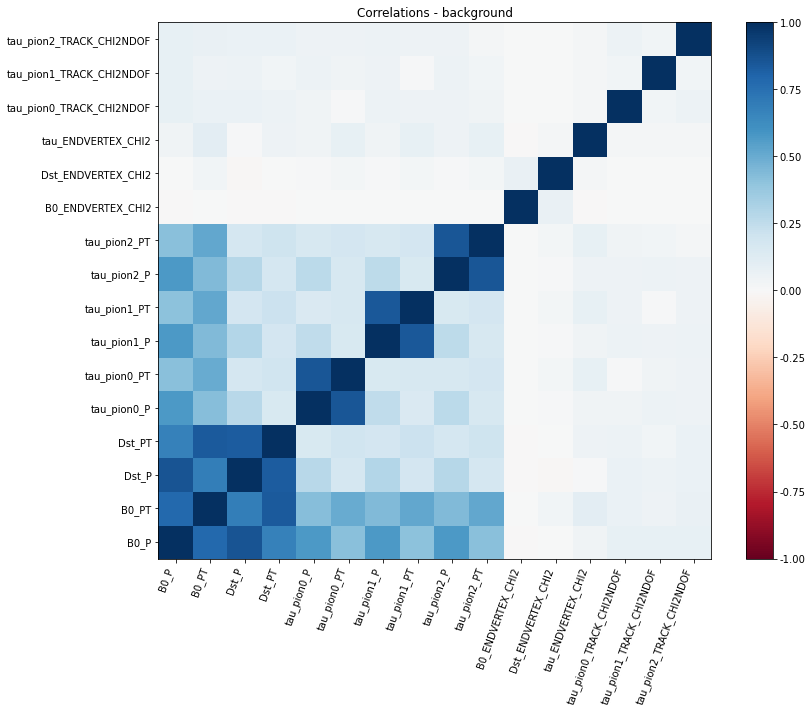

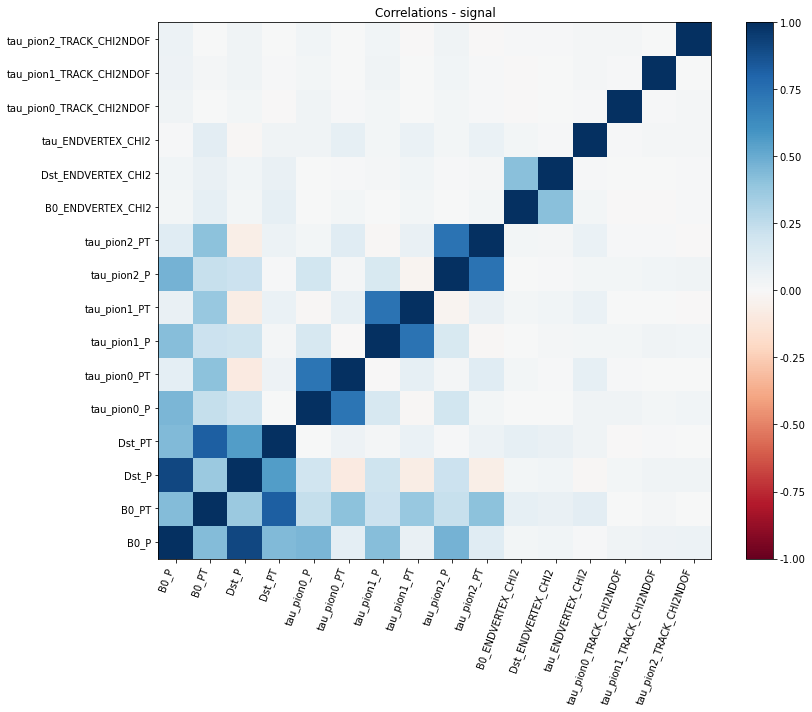

In [30]:
# remove the y column from the correlation matrix
# after using it to select background and signal
print("Background")
correlations(df[bg].drop('y', 1),name_file= 'background') # Drop the column(->1) 'y'
print("Signal")
correlations(df[sig].drop('y', 1),name_file= 'signal')

## Task 1 - Use the wrong-sign data samples and the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ signal MC to train a BDT. The BDTs job will be to classify events as signal or combinatorial background. You will need to choose some input variables from your tree to train the classifier (see below).

## Import

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

## Training and Testing Split

We want to split our data into:
- $1-0.33$: **development set**
    - $(1-0.33)\times (1-0.33)$ :  **training set**: to train the BDT and fit the parameters
    - $(1-0.33)\times 0.33$ : **testing set**: set used to tune the hyperparameters of the classifier (for instance here, I suppose the depth of the BDT, ...)
- $0.33$: **evaluation set** to evaluate the performance of the BDT, and to check that the BDT is not overtrained

We rather do
- $0.5$ :  **training set**: to train the BDT and fit the parameters
- $0.5$ : **testing set**: set used to see if there is overtraining 

In [34]:
print(df.columns)
indices = [list(df.columns).index(e) for e in ('B0_P','Dst_P','tau_pion0_P','tau_pion1_P','tau_pion2_P')]
X2 = np.delete(X, indices, 1)

Index(['B0_P', 'B0_PT', 'Dst_P', 'Dst_PT', 'tau_pion0_P', 'tau_pion0_PT',
       'tau_pion1_P', 'tau_pion1_PT', 'tau_pion2_P', 'tau_pion2_PT',
       'B0_ENDVERTEX_CHI2', 'Dst_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2',
       'tau_pion0_TRACK_CHI2NDOF', 'tau_pion1_TRACK_CHI2NDOF',
       'tau_pion2_TRACK_CHI2NDOF', 'y'],
      dtype='object')


In [63]:
print(list(df.columns)+['y'])

['B0_P', 'B0_PT', 'Dst_P', 'Dst_PT', 'tau_pion0_P', 'tau_pion0_PT', 'tau_pion1_P', 'tau_pion1_PT', 'tau_pion2_P', 'tau_pion2_PT', 'B0_ENDVERTEX_CHI2', 'Dst_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2', 'tau_pion0_TRACK_CHI2NDOF', 'tau_pion1_TRACK_CHI2NDOF', 'tau_pion2_TRACK_CHI2NDOF', 'y', 'y']


In [35]:
X_train,X_test, y_train,y_test = train_test_split(X, y,test_size=0.5)
X2 = np.delete(X, indices, 1)
X2_train,X2_test, y2_train,y2_test = train_test_split(X2, y,test_size=0.5)
print(np.shape(X))
print(np.shape(X2))

(381559, 16)
(381559, 11)


### Training

In [36]:
def BDT(X,y):
    # Separate train/test data
    X_train,X_test, y_train,y_test = train_test_split(X, y,test_size=0.5)
    ## Define the Decision Tree
    dt = DecisionTreeClassifier(max_depth=3,
                                min_samples_leaf=0.05) # The minimum number of samples required to be at a leaf node
    # here, since it's a float, it is expressed in fraction of len(X_train)
    # We need min_samples_leaf samples before deciding to create a new leaf

    ## Define the BDT
    bdt = AdaBoostClassifier(dt,
                             algorithm='SAMME',
                             n_estimators=800, # Number of trees 
                             learning_rate=0.5) # Learning rate shrinks the contribution of each tree by alpha
    ## Learning (fit)
    bdt.fit(X_train, y_train)
    return X_train, y_train, X_test, y_test, bdt



print(1)
X_train, y_train, X_test, y_test, bdt = BDT(X, y)
print(2)
X2_train, y2_train, X2_test, y2_test, bdt2 = BDT(X2, y)

1
2


### Assessment
AUC

In [45]:
def classification_report_print(X_test, y_test, bdt,name_BDT = ""):
    y_predicted = bdt.predict(X_test)
    classification_report_str = classification_report(y_test, y_predicted,
                                target_names=["background", "signal"])
    print(classification_report_str)
    ROC_AUC_score = roc_auc_score(y_test, # real
                                    bdt.decision_function(X_test)) # scores = returns a Numpy array, In which each element represents whether a predicted sample for x_test by the classifier lies to the right or left side of the Hyperplane and also how far from the HyperPlane.
    print("Area under ROC curve: %.4f"%(ROC_AUC_score))

    if name_BDT != "":
        name_BDT = '_' + name_BDT
    with open(f"{loc.TABLES}/BDT/classification_report{name_BDT}.txt", 'w') as f:
        f.write(classification_report_str)
        f.write("Area under ROC curve: %.4f"%(ROC_AUC_score))
    
print(1)
classification_report_print(X_test, y_test, bdt,"all_vars")

print(2)
classification_report_print(X2_test, y2_test, bdt2,"without_P_vars")

1
              precision    recall  f1-score   support

  background       0.97      0.99      0.98    178968
      signal       0.75      0.61      0.67     11812

    accuracy                           0.96    190780
   macro avg       0.86      0.80      0.83    190780
weighted avg       0.96      0.96      0.96    190780

Area under ROC curve: 0.9754
2
              precision    recall  f1-score   support

  background       0.97      0.98      0.98    179044
      signal       0.71      0.55      0.62     11736

    accuracy                           0.96    190780
   macro avg       0.84      0.77      0.80    190780
weighted avg       0.95      0.96      0.96    190780

Area under ROC curve: 0.9669


ROC curve

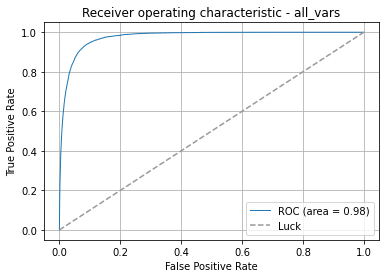

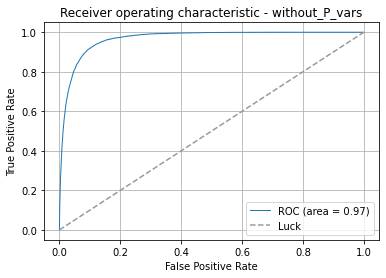

<Figure size 432x288 with 0 Axes>

In [46]:
def plot_roc(X_test, y_test, bdt,name_BDT = ""):
    decisions = bdt.decision_function(X_test) # result of the BDT of the test sample
    fpr, tpr, thresholds = roc_curve(y_test, decisions) # roc_curve
    # y_test: true results
    # decisions: result found by the BDT
    # fpr: Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].
    # tpr: Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
    # thresholds: Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'Receiver operating characteristic'
    if name_BDT is not None:
        title += f" - {name_BDT}"
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    if name_BDT != "":
        name_BDT = '_' + name_BDT
    plt.savefig(f"{loc.PLOTS}/BDT/ROC{name_BDT}.pdf")
    
plot_roc(X_test, y_test, bdt, 'all_vars')
plot_roc(X2_test, y2_test, bdt2,"without_P_vars")

### Overtraining check

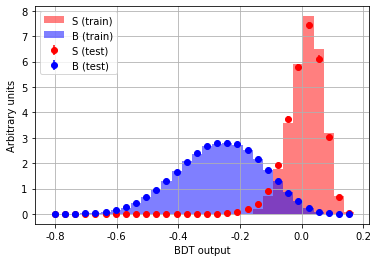

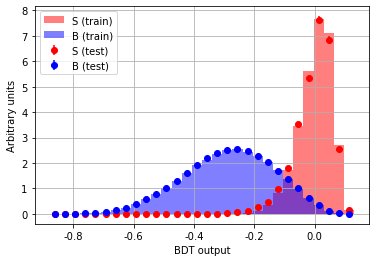

In [50]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30, name_BDT = ""):
    """
    clf: bdt
    """
    ## decisions = [d(X_train_background), d(X_train_signal),d(X_test_background), d(X_test_signal)]
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2] # [background, signal]
    
    
    ## Range of the full plot
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    
    ## Plot for the train data the stepfilled histogram of background (y<0.5) and signal (y>0.5) 
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    ## Plot for the test data the points with uncertainty of background (y<0.5) and signal (y>0.5) 
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    # Compute and rescale the error
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    # Compute and rescale the error
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.grid()
    
    if name_BDT != "":
        name_BDT = '_' + name_BDT
    plt.savefig(f"{loc.PLOTS}/BDT/overtraining{name_BDT}.pdf")
    plt.show()
    plt.close()
    
compare_train_test(bdt, X_train, y_train, X_test, y_test,name_BDT = 'all_vars')
compare_train_test(bdt2, X2_train, y2_train, X2_test, y2_test,name_BDT = 'without_P_vars')

### Task 2 - Apply this BDT to the signal data, which has not been used in the training. The result should be a BDT distribution for the signal data, with high values corresponding to a high signal probability and a low value corresponding to a high background probability.

In [60]:
from root_numpy import array2root
# Recall : dfa['data_strip'], dfa_tot['data_strip'] = load_data(years[:1],magnets[:1],type_data = 'data_strip',vars = variables)
y_predicted = bdt.decision_function(dfa_tot['data_strip'])
y_predicted.dtype = [('y', np.float64)]


[1. 1. 1. ... 0. 0. 0.]


In [61]:
array2root(y_predicted, loc.OUT +"tmp/test-prediction.root", "BDT")

## Recover the files - different ways to do it (not finished)

I'm going to try 2/3 ways to retrieve the files:
- with the current method (read_root)
- with uproot

In [4]:
def load_data(years,magnets,type_data = 'data', vars = None,method='read_root'):
    """
    type_data = 'MC', 'data', 'data_strip', 'ws_strip'
    """
    tree_name = "DecayTree"
    if type_data == 'MC':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    elif type_data == 'data':
        path = f"{loc.DATA}/data_90000000"
        ext = '.root'
    elif type_data == 'MCc':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09c-ReDecay01.root'
    elif type_data == 'MCe':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    elif type_data == 'data_strip':
        path = f"{loc.DATA_STRIP}/data_90000000"
        ext = '.root'
        tree_name = "DecayTreeTuple/DecayTree"
    elif type_data == 'ws_strip':
        path = f"{loc.DATA_WS_STRIP}/dataWS_90000000"
        ext = '.root'
        tree_name = "DecayTreeTuple/DecayTree"
    else:
        print("Possible type of data: 'MC', 'data', 'data_strip', 'ws_strip'")
    
    dfr = {}
    dfr_tot = pd.DataFrame()
    for y in years:
        for m in magnets:
            print(f"{path}_{y}_{m}{ext}")
            if method == 'read_root':
                dfr[f"{y}_{m}"] = read_root(f"{path}_{y}_{m}{ext}",tree_name, columns=vars)
            if method == 'uproot':
                file = uproot4.open(f"{path}_{y}_{m}{ext}")[tree_name]
                dfr[f"{y}_{m}"]=file.arrays(vars, library = "pd")
                del file
            dfr_tot = dfr_tot.append(dfr[f"{y}_{m}"])
    return dfr, dfr_tot

## B0_M with BDT

In [28]:
part_variables_to_plot = [] # particle,variable

for particle in ['B0', 'Dst', 'tau_pion0', 'tau_pion1', 'tau_pion2']:
    part_variables_to_plot.append((particle,'P'))
    part_variables_to_plot.append((particle,'PT'))

for particle in ['B0', 'Dst', 'tau']:
    part_variables_to_plot.append((particle,'ENDVERTEX_CHI2'))

for particle in ['tau_pion0', 'tau_pion1', 'tau_pion2']:
    part_variables_to_plot.append((particle,'TRACK_CHI2NDOF'))

for particle in ['B0','Dst', 'D0']:
    part_variables_to_plot.append((particle,'M'))
variables = []
for particle, variable in part_variables_to_plot:
    variables.append(f"{particle}_{variable}")
#variables.append('B0_M')
print(variables)


['B0_P', 'B0_PT', 'Dst_P', 'Dst_PT', 'tau_pion0_P', 'tau_pion0_PT', 'tau_pion1_P', 'tau_pion1_PT', 'tau_pion2_P', 'tau_pion2_PT', 'B0_ENDVERTEX_CHI2', 'Dst_ENDVERTEX_CHI2', 'tau_ENDVERTEX_CHI2', 'tau_pion0_TRACK_CHI2NDOF', 'tau_pion1_TRACK_CHI2NDOF', 'tau_pion2_TRACK_CHI2NDOF', 'B0_M', 'Dst_M', 'D0_M']


In [ ]:
# Test of uproot
import time
start = time.time()
df_tot = {}
_, df_tot['data_strip'] = load_data(years[:1],magnets[:1],type_data = 'data_strip',method = 'uproot')
end = time.time()
print(end - start, 's')

In [ ]:
import time
start = time.time()
df_tot = {}
_, df_tot['data_strip'] = load_data(years[:1],magnets[:1],type_data = 'data_strip')
end = time.time()
print(end - start, 's')

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root


In [6]:
df_tot = {}
_, df_tot['data_strip'] = load_data(years,magnets,type_data = 'data_strip',vars = variables)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_down.root


In [7]:
low = 5050.
high = 5550.
d = 'data_strip'
df_tot[d]["Delta_M"] = df_tot[d]["Dst_M"] - df_tot[d]["D0_M"]
df_tot[d+'_cut'] = df_tot[d].query("Delta_M > 143. and Delta_M < 148.")
df_tot[d+'_cut'] = df_tot[d+'_cut'].query(f"B0_M < {high} and B0_M > {low}")
# for particle in 'Dst', 'D0':
#     df_tot[d]=df_tot[d].drop(f'{particle}_M', 1)
# df_tot[d]=df_tot[d].drop('Delta_M', 1)

In [11]:
df_tot['data_strip']['y'] = read_root(loc.OUT+'tmp/BDT_output_without_P.root', 'BDT', columns=['y'])
df_tot['data_strip_cut']['y'] = read_root(loc.OUT+'tmp/BDT_output_without_P_with_cut.root', 'BDT', columns=['y'])

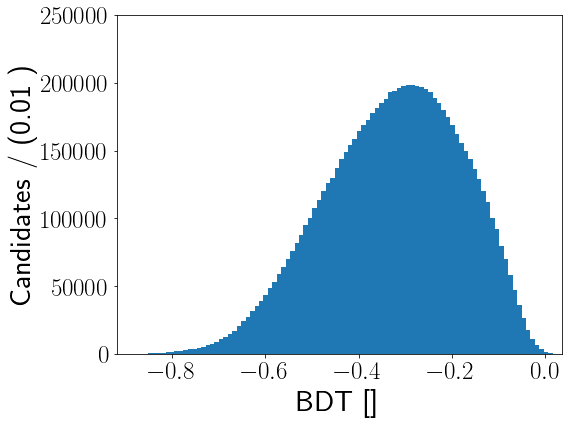

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


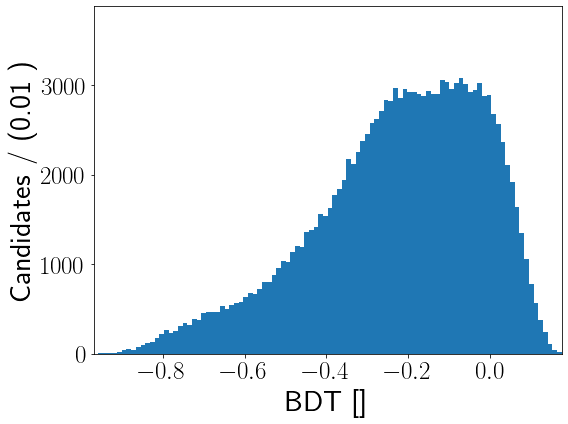

In [32]:
#dfa_tot['data_strip']['y']
plot_hist({'data':df_tot['data_strip']},'y', 'BDT', '', n_bins = 100,mode_hist = True)
plot_hist({'data':df_tot['data_strip_cut']},'y', 'BDT', '', n_bins = 100,mode_hist = True)

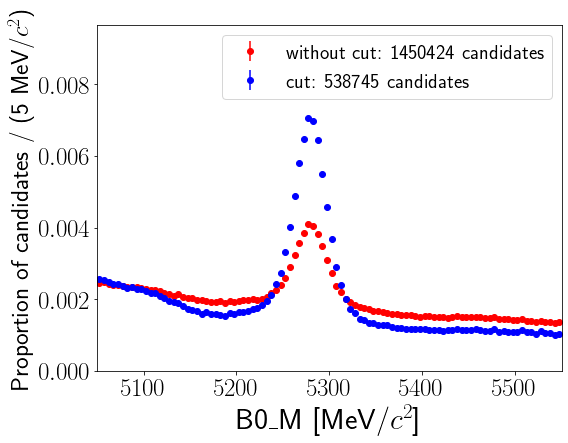

In [57]:
plot_hist({'without cut':df_tot['data_strip'],'cut':df_tot['data_strip_cut']},'B0_M', 'B0\_M', 'MeV/$c^2$',low = low,high=high, n_bins = 100)

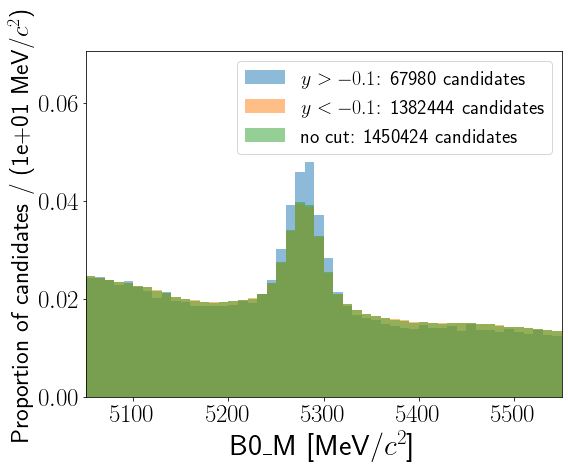

In [78]:
plot_hist({'$y>-0.1$':df_tot['data_strip'].query('y>-0.1'),
           '$y<-0.1$':df_tot['data_strip'].query('y<-0.1'),
          'no cut':df_tot['data_strip']},
          'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)


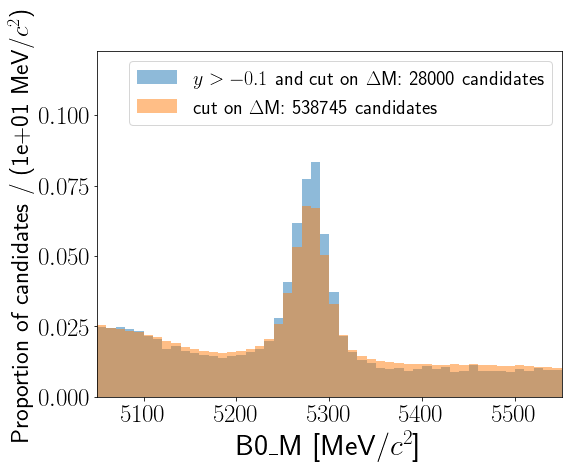

In [82]:
plot_hist({'$y>-0.1$ and cut on $\Delta$M': df_tot['data_strip'].query("y>-0.1 and Delta_M > 143. and Delta_M < 148."),
           'cut on $\Delta$M':df_tot['data_strip'].query('Delta_M > 143. and Delta_M < 148.')},
          'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)

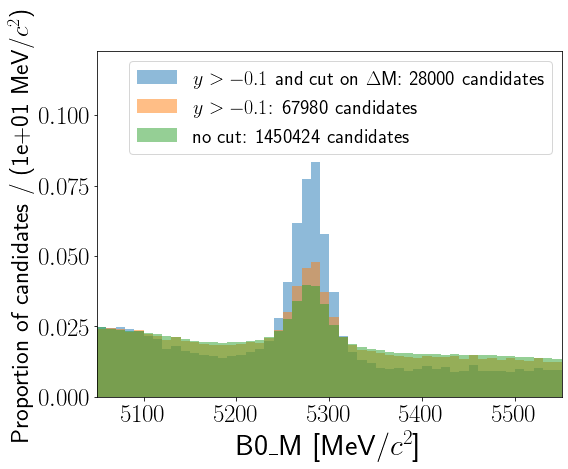

In [77]:
plot_hist({'$y>-0.1$ and cut on $\Delta$M': df_tot['data_strip'].query("y>-0.1 and Delta_M > 143. and Delta_M < 148."),
           '$y>-0.1$':df_tot['data_strip'].query('y>-0.1'),
          'no cut':df_tot['data_strip']},
          'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)


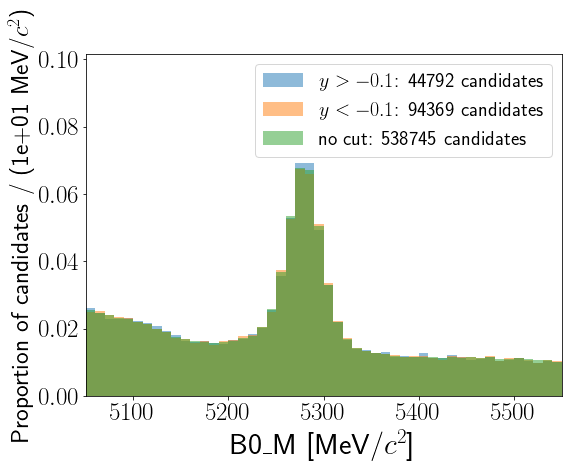

In [76]:
plot_hist({'$y>-0.1$':df_tot['data_strip_cut'].query('y>-0.1'),
           '$y<-0.1$':df_tot['data_strip_cut'].query('y<-0.1'),
          'no cut':df_tot['data_strip_cut']},
          'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)

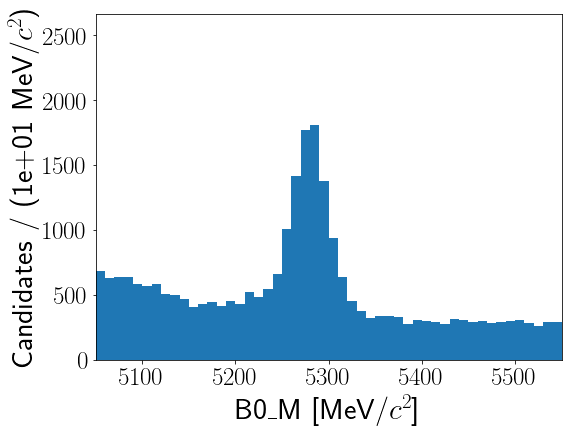

In [67]:
plot_hist({'$y<-0.2$':df_tot['data_strip_cut'].query('y<-0.4')},'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)

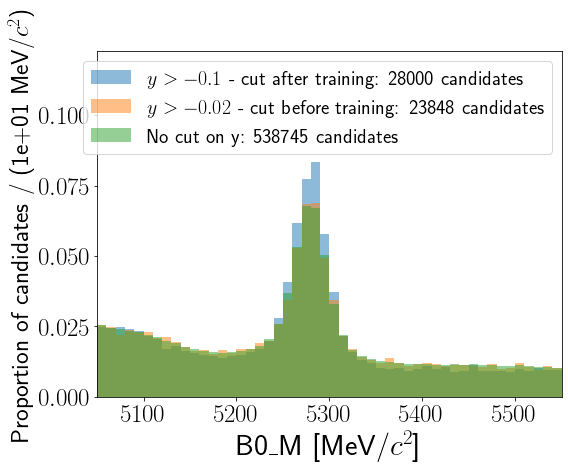

In [91]:
plot_hist({'$y>-0.1$ - cut after training': df_tot['data_strip'].query("y>-0.1 and Delta_M > 143. and Delta_M < 148."),
           '$y>-0.02$ - cut before training': df_tot['data_strip_cut'].query("y>-0.02"),
           'No cut on y':df_tot['data_strip'].query('Delta_M > 143. and Delta_M < 148.')},
          'B0_M', 'B0\_M', 'MeV/$c^2$', n_bins = 50,low = low,high=high,mode_hist=True)